In [12]:
import infusion as inf
from infusion import Dataset, Troughs
from infusion import bandpass, rates

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def vclip(x, bounds=[0, 60]):
    bnds = torch.tensor(bounds)
    return torch.min(torch.max(bnds[0], x), bnds[1])

### Read infusion timestamps

tensor([10240000., 30720000.])


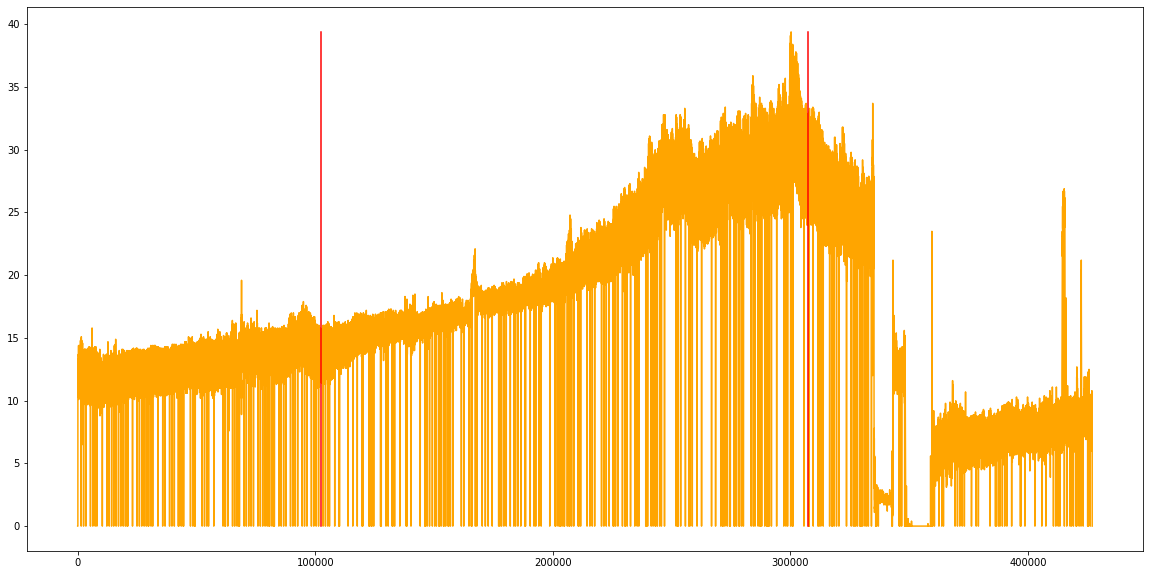

In [45]:
db = Dataset("full")
fs = 100

file    = db.get(3500)
periods = db.periods[file.key]
inf     = fs * (torch.tensor(periods['infusion'])
                - periods['start'])

icp_full = vclip(file.icp())
icp_min, icp_max = icp_full.min(), icp_full.max()

print(inf * 100)

plt.figure(figsize=(20, 10))
plt.plot(icp_full, color="orange")
plt.plot([inf[0]] * 2, [icp_min, icp_max], color="red")
plt.plot([inf[1]] * 2, [icp_min, icp_max], color="red")

### Segment the raw signal

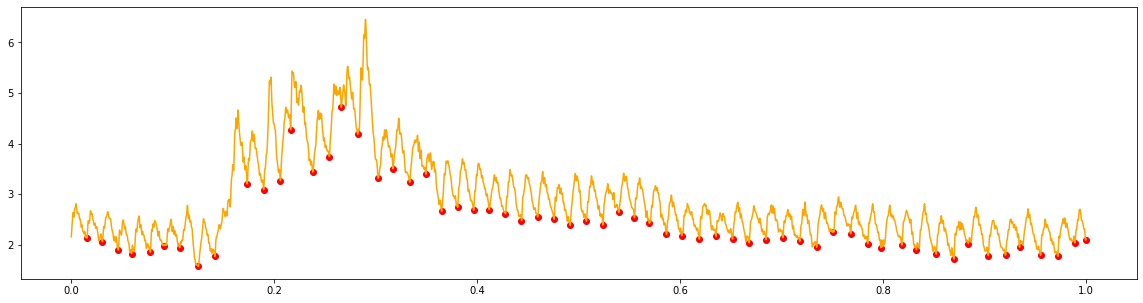

In [25]:

N = 6000
time = torch.arange(N) / (fs * 60)
troughs = Troughs(N, 40)

file = db.get(2)
icp_raw = vclip(file.icp(1000, N))

bp   = bandpass(0, 12, fs)
icp  = bp(icp_raw)
t    = troughs(icp)

plt.figure(figsize=(20, 5))
plt.plot(time, icp, color='orange')
plt.scatter(time[t], icp[t], color='red')
plt.show()

### Model image of the segments

In [26]:
from models   import ConvNet
from infusion import segment, mask_center, diff
from time import time

# model trained on synthetic augmentations only
# (noise, scalings, dc shifts) - see experiments/twins.py
model = ConvNet.load("pretrained.pt")

# centered segments
pulses, mask = segment(icp, t, 128, before=0)
x, x_mean, x_slope = mask_center(pulses, mask, output='slopes')

# model output
with torch.no_grad():
    y  = model(x).detach()
    dy = diff(y.T).T
    ym = y - y.mean([0])[None,:]
    
# variations in model output
q = (ym.norm(p=2, dim=[1])
  +  dy.norm(p=2, dim=[1]))
q /= 3

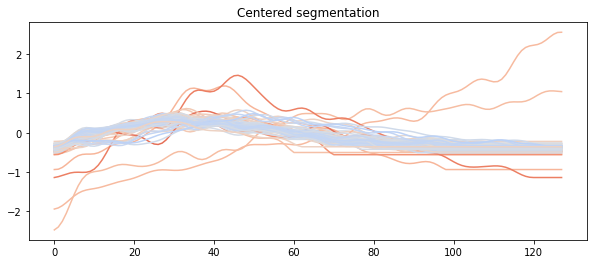

In [27]:
color=cm.coolwarm(q)

plt.figure(figsize=(10, 4))
for xi, ci in zip(x, color):
    plt.plot(xi, color=ci)
plt.title("Centered segmentation")
plt.show()

### Filtering of pulses

#### Model output variation

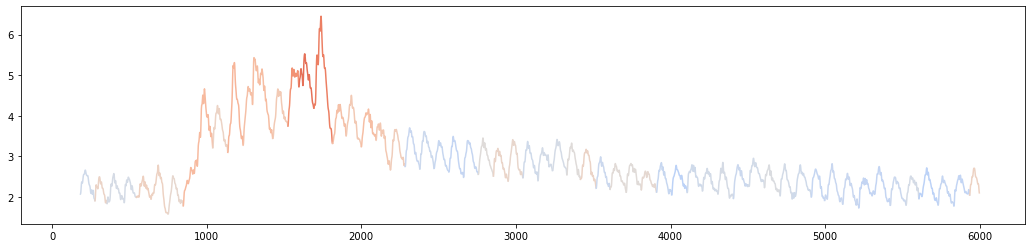

In [28]:
plt.figure(figsize=(18, 4))
for i, j, cij in zip(t[:-1], t[1:], color):
    ij = i + torch.arange(j - i)
    pij = icp[i:j]
    plt.plot(ij, pij, color=cij)

n_slices: 60


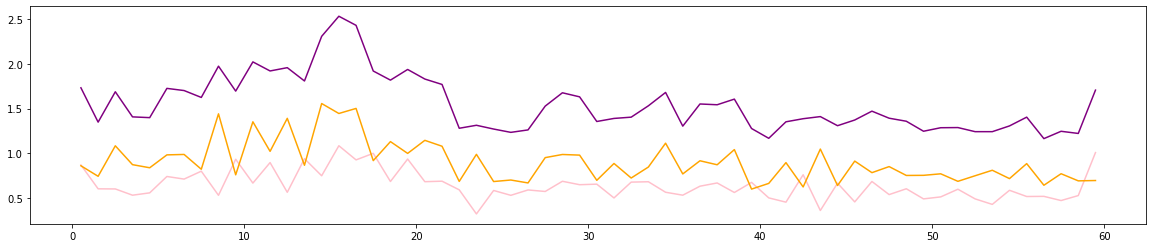

In [29]:
# Time dependence
plt.figure(figsize=(20, 4))
idx = torch.arange(y.shape[0])
plt.plot(.5 + idx, dy.norm(dim=[1]), color="pink")
plt.plot(.5 + idx, ym.norm(dim=[1]), color="orange")
plt.plot(.5 + idx, ym.norm(dim=[1]) + dy.norm(p=2, dim=[1]), color="purple")
print(f"n_slices: {pulses.shape[0]}")

#### Model clusters

In [30]:
from models.kmeans import KMeans
from infusion.data import Pulses

with torch.no_grad():
    x_full = Pulses('full').pulses[:64].view([-1, 128])
    y_full = model(x_full)

# km = KMeans(64)
# km.fit(y_full.cuda()).cpu()
km = KMeans.load("km_pretrained.pt")

In [31]:
y = model(x).detach()
z = km.predict(y)

print(f"Predictions:\n {z}")

Predictions:
 tensor([61, 61, 47, 53, 61, 61, 54, 37, 61, 61, 53, 54, 55, 54,  9, 56, 57, 61,
        37, 37, 44, 62, 61, 37, 37, 61, 61, 61, 52, 44, 61, 51, 61, 61,  3, 61,
         3, 61, 52, 60, 36, 61, 61, 54, 61, 61, 61, 36, 61, 61, 54, 16, 61, 36,
        61, 20, 61, 61, 16, 54])


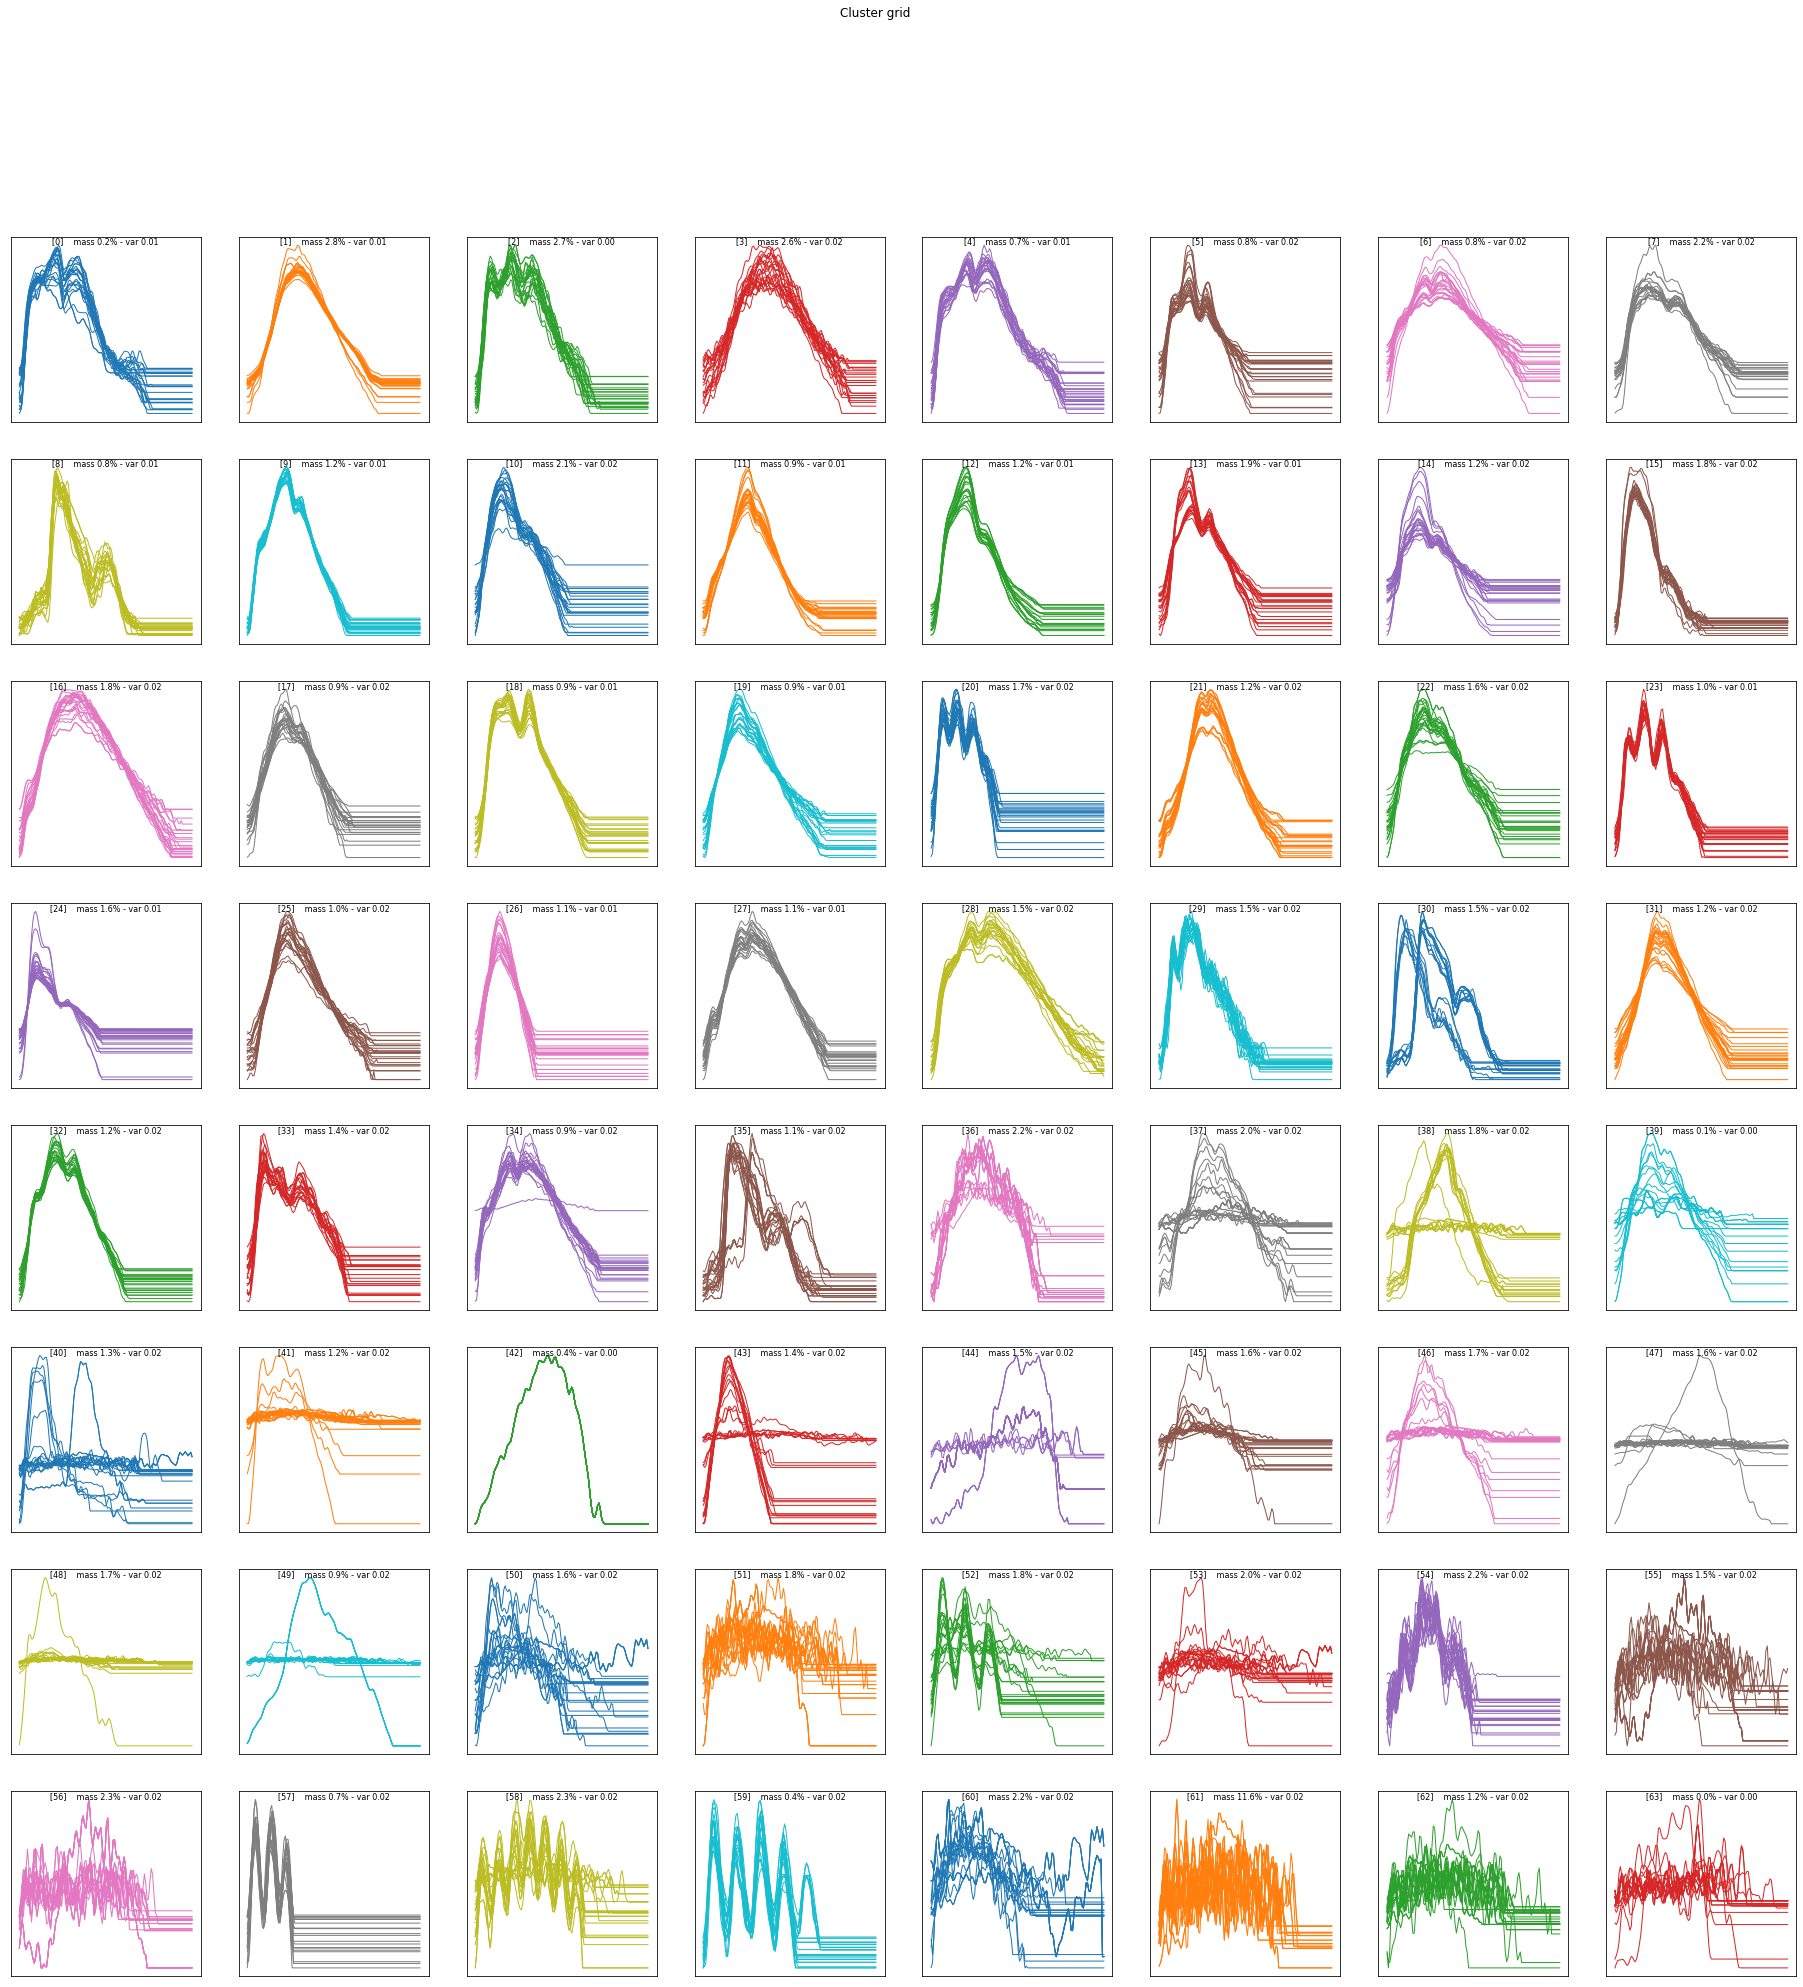

In [32]:
import revert.plot as rp
km = KMeans.load("km_pretrained.pt")
rp.cluster_grid(km, x_full, y_full, 24)

In [33]:
km.swap(43, 35)
km.save("km_pretrained.pt")

Text(0.5, 1.0, 'activations')

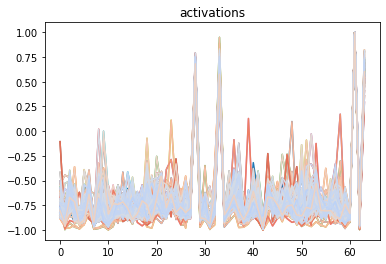

In [34]:
 plt.plot(y.T)
for yi, ci in zip(y, color):
    plt.plot(yi, color=ci)
plt.title("activations")